In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset

dataset = load_dataset('emotion')

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something', 0)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


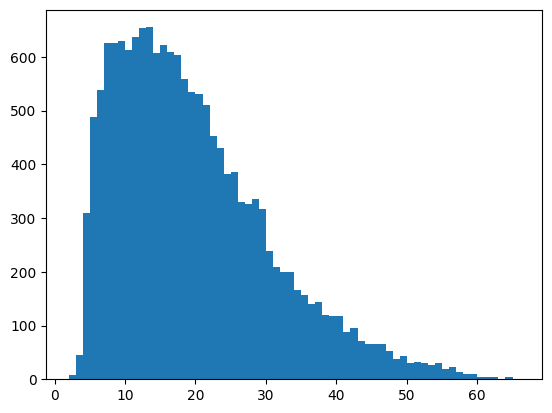

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

In [14]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [15]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [16]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


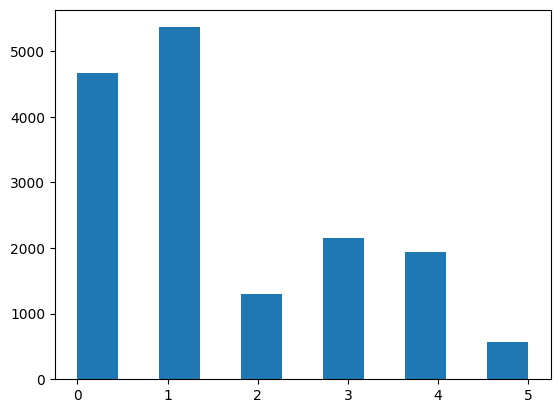

In [17]:
plt.hist(labels, bins=11)
plt.show()

In [18]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [19]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [20]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=40),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),  # first RNN layer
    tf.keras.layers.SimpleRNN(32),                          # second RNN layer
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [23]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', np.int64(4))

In [24]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3262 - loss: 1.5876 - val_accuracy: 0.3425 - val_loss: 1.5840
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3532 - loss: 1.5566 - val_accuracy: 0.3770 - val_loss: 1.5748
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4399 - loss: 1.4804 - val_accuracy: 0.5345 - val_loss: 1.3326
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6280 - loss: 1.0435 - val_accuracy: 0.6180 - val_loss: 1.1174
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7530 - loss: 0.7031 - val_accuracy: 0.6355 - val_loss: 1.0529
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8363 - loss: 0.5001 - val_accuracy: 0.6280 - val_loss: 1.1850
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8805 - loss: 0.3676 - val_accuracy: 0.6060 - val_loss: 1.3044


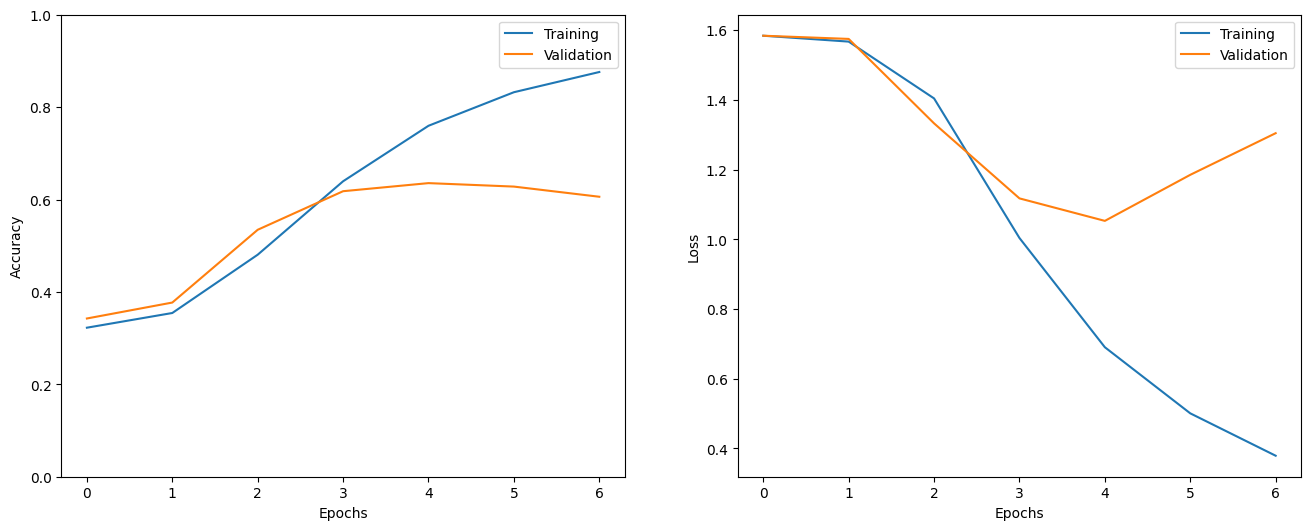

In [25]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [26]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [27]:
eval = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6436 - loss: 1.1848


In [28]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(test_sequences)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(test_labels)
print(type(y_pred))
print(type(y_true))

# Convert integer labels back to class names
##target_names = [index_to_classes[i] for i in range(len(classes))]

print(classification_report(y_true, y_pred, target_names=list(['0','1','2','3','4','5'])))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       581
           1       0.83      0.69      0.75       695
           2       0.19      0.11      0.14       159
           3       0.40      0.61      0.48       275
           4       0.40      0.34      0.37       224
           5       0.09      0.05      0.06        66

    accuracy                           0.64      2000
   macro avg       0.45      0.45      0.44      2000
weighted avg       0.63      0.64      0.63      2000



In [29]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

  # Get the index of the predicted emotion
  predicted_emotion_index = np.argmax(p)

  print('Predicted Emotion:', index_to_classes.get(predicted_emotion_index), '\n')

Tweet: i can say is that as long as you enjoy the story it entertains you and makes you feel emotional whether it be sad happy angry disgusted or just plain horny then who really gives a damn
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicted Emotion: 0 

Tweet: i have made about sex i feel that women enjoy sex when their body and emotions are admired and respected
Actual Emotion: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Emotion: 1 

Tweet: i often feel discouraged and frustrated and i am not where i want to be in life right now
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Emotion: 0 

Tweet: i forgive myself for accepting and allowing myself to have the feeling that i am going to get punished for doing something wrong
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Emotion: 0 

Tweet: i started out feeling discouraged this morning
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Emotion: 0 

